## Поиск источника девиаций по данным Splunk

In [1]:
import splunklib
import splunklib.client as client
import splunklib.results as results

import datetime as dt
from time import sleep

import numpy as np
import pandas as pd
from pandas import Series, DataFrame

import matplotlib as mpl
import matplotlib.pyplot as plt

#%matplotlib notebook

In [2]:
#Подключение

HOST = "splunk-search01.roamability.com"
PORT = 8089
USERNAME = "pavel"
PASSWORD = "O777ver7k1"
# Create a Service instance and log in 
service = client.connect(
    host=HOST,
    port=PORT,
    username=USERNAME,
    password=PASSWORD)

In [3]:
#Создаем необходимые процедуры

log_level = 0

def outLog(message, level=1):
    if(level <= log_level):
        print (message)
        sys.stdout.flush()

def FormatSplunkEngineDate(dt): return dt.strftime("%Y-%m-%dT%H:%M:%S")

In [27]:
#Указываем время, запрос и запускаем запрос

dateFrom = dt.datetime.strptime('2018-06-20T00:00:00', '%Y-%m-%dT%H:%M:%S')
dateTo = dt.datetime.strptime('2018-06-21T06:00:00', '%Y-%m-%dT%H:%M:%S')
searchquery_export =\
'''
search index=sdr (4250196* OR 26006*) PROTOCOL=S6a ANS_RES_CODE=2001
| eval CODE_TEMP=case(isnotnull(ANS_RES_CODE),ANS_RES_CODE,isnull(ANS_RES_CODE), ANS_EXP_RES_CODE, isnull(ANS_EXP_RES_CODE), EXP_RES_CODE, isnull(EXP_RES_CODE), RES_CODE)
| eval CODE=if(isnotnull(CODE_TEMP), CODE_TEMP, "PUR_NOR") | eval CUSTOMER=coalesce(THIRD_PARTY,MVNO)
| Timechart span=15m count by CUSTOMER  | table * | sort by _time
'''

In [66]:
## Исправленный вариант на основе:
#http://docs.splunk.com/DocumentationStatic/PythonSDK/1.6.3/client.html#splunklib.client.Job.results

bEchoTime = False

sfrom = dateFrom if  bEchoTime else FormatSplunkEngineDate(dateFrom) 
sto = dateTo if  bEchoTime else FormatSplunkEngineDate(dateTo)
kwargs_export = {"earliest_time": sfrom,
                 "latest_time":sto ,
                 "search_mode": "normal",
                 #"output_mode":"JSON",
                 #"rf" : fields,
                 "supports_multivalues":True
                 }

job = service.jobs.create(searchquery_export, **kwargs_export)
while not job.is_done():
    sleep(.2)
rr = results.ResultsReader(job.results())

outputResult = list()
i=0

for result in rr:
            if isinstance(result, dict):
                outputResult.append(result)
assert rr.is_preview == False

df=DataFrame(outputResult,dtype='int64')
df['rep_date']=pd.to_datetime(df['_time'])
df.drop(['_time','_span'],axis=1,inplace=True)
df.tail()

,C9,MB,Maxcom,Mondicon,NAKA,OTHER,PuertoSeguro,Rewicom,Roamability,Telzar,Tinklabs,rep_date
95,632,231,0,41,2066,1,180,0,311,3323,337,2018-06-20 21:45:00
96,574,233,2,49,2064,1,169,1,273,3190,274,2018-06-20 22:00:00
97,803,626,5,214,2369,0,151,0,333,3505,257,2018-06-20 22:15:00
98,702,424,0,121,2422,0,139,1,287,3233,9968,2018-06-20 22:30:00
99,590,260,1,135,2123,2,173,1,251,2859,1951,2018-06-20 22:45:00


In [ ]:
df['MB'].head()
x=np.linspace(0,10,df['MB'].count())
f_hat = lo.lowess(x, df['MB'], x)
plt.plot(df['MB'], color='black', label=who)
plt.plot(f_hat, label=who)
plt.show()

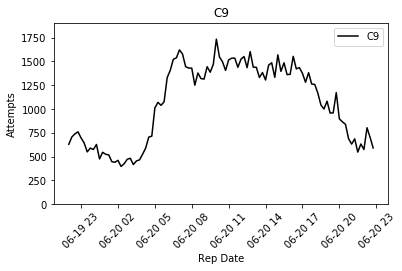

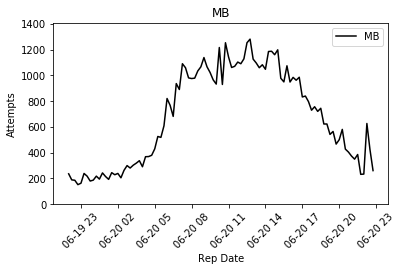

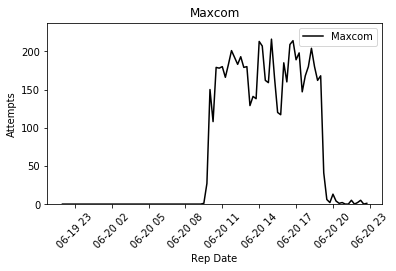

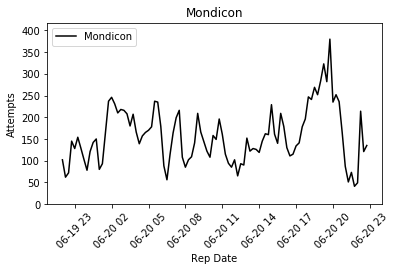

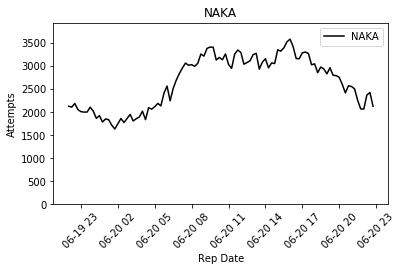

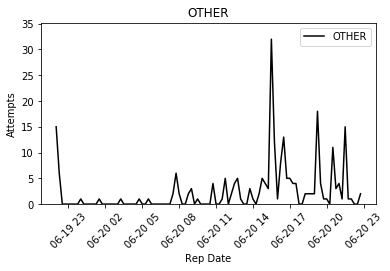

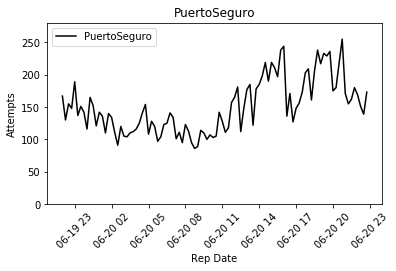

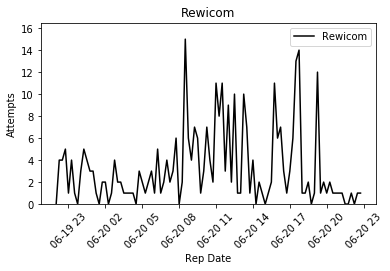

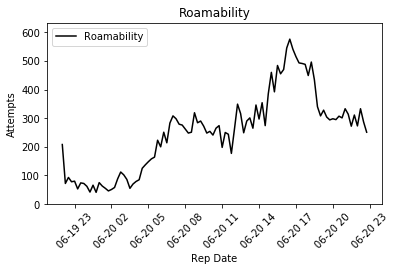

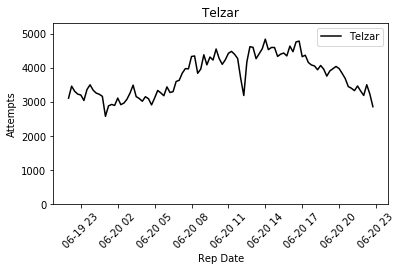

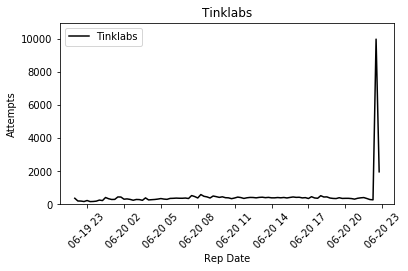

In [136]:
customers=list(df.columns)
customers.remove('rep_date')

x = np.linspace(0,10,df['rep_date'].count())

for who in customers:
    plt.figure()
    plt.plot(df['rep_date'],df[who], color='black', label=who) #Простая линия. Справка по параметрам plt.plot?
    plt.xlabel('Rep Date') #Опцианально. add a label to the x axis
    plt.ylabel('Attempts') #Опцианально. add a label to the y axis
    plt.title(who) #Опцианально. Заголовок графика.
    plt.legend() #Опцианально. Выводит пояснение к графикам если заданы параметры label. Или можно plt.legend(['Simple line','Red balls']) Справка plt.legend().
    plt.ylim([0,float(max(df[who]))*1.1])
    
    x = np.linspace(0,10,df[df[who]!=0][who].count())
    f_hat = lo.lowess(x, df[df[who]!=0][who], x)
    
    x = plt.gca().xaxis
    # rotate the tick labels for the x axis
    for item in x.get_ticklabels():
        item.set_rotation(45)
    # adjust the subplot so the text doesn't run off the image
    plt.subplots_adjust(bottom=0.25)
    plt.show() #можно не вводить при использовании backend 'nbAgg'

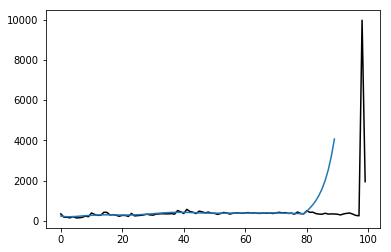

In [123]:
df['Tinklabs'].head()
x=np.linspace(0,10,df['Tinklabs'].count())
f_hat = lo.lowess(x, df['Tinklabs'], x0)
plt.plot(df['Tinklabs'], color='black', label=who)
plt.plot(f_hat, label=who)
plt.show()

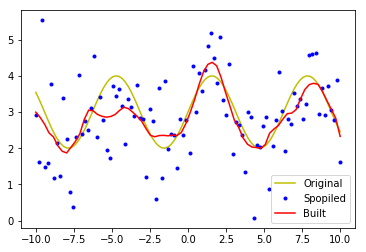

In [92]:
import lowess as lo
import numpy as np
# For the 1D case:
i=100 #Кол-во элементов исходной функции
x=np.linspace(-10,10,i)
f_orig = np.sin(x) + 3
f = np.sin(x) + np.random.normal(loc=3,scale=1,size=i)
j=70 #Кол-во элементов наложенной функции
x0 = np.linspace(-10,10,j)
f_hat = lo.lowess(x, f, x0)
import matplotlib.pyplot as plt
fig,ax = plt.subplots(1)
ax.plot(x,f_orig,'y', label='Original') #исходный график
ax.plot(x,f,'b.', label='Spopiled') #график с разбросами
ax.plot(x0,f_hat,'r', label='Built') #восстановленный график методом lowess
plt.legend()
plt.show()